# Experiments with Model 2

In [125]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from uniform_encoders import *

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
# sns.set(context='paper', style='white', font='CMU Serif')
sns.set(context='paper', style='white', font='CMU Serif', rc={'font.size':10, 'mathtext.fontset': 'cm'})

In [126]:
class Inputs():
    def __init__(self, nCS=1, nCTX=2, dim_CS=3, dim_CTX=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = ScatteredHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
        self.stop_learning = 0  # control signal to turn learning off
        self.applied_current = 0  # for experiments with external perturbation
    def get_CS(self, t):
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        return self.CS if applied else np.zeros((self.dim_CS))
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        applied = True if t%2>1.5 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0
    def get_stop_learning(self, t):
        return self.stop_learning
    def get_applied_current(self, t):
        return self.applied_current

In [127]:
def build_network(
        dt = 0.001,
        nCond = 5,
        nExt = 10,
        seed = 0,
        nNeurons = 100,
        dim_CS = 3,
        dim_CTX = 5,
        nCS = 1,
        nCTX = 3,
        intercept_CS = 0,
        intercept_CTX = 0,
        intercept_LA_pyr = -0.2,
        lr1 = 3e-5,
        lr2 = 3e-4,
        lr3 = 1e-5,
        T_BLA_CS=0.25,
        T_BLA_CTX=0.75,
    ):

    rng = np.random.RandomState(seed=seed)
    sampler = ScatteredHypersphere(surface=True)
    inputs = Inputs(dim_CS=dim_CS, dim_CTX=dim_CTX, nCS=nCS, nCTX=nCTX, seed=seed)
    encoders_LA_pyr = sampler.sample(2*nNeurons, 2, rng=rng)
    intercepts_LA_pyr = nengo.dists.Uniform(intercept_LA_pyr, intercept_LA_pyr)
    encoders_CS = sampler.sample(dim_CS*nNeurons, dim_CS, rng=rng)
    encoders_CTX = sampler.sample(dim_CTX*nNeurons, dim_CTX, rng=rng)
    intercepts_CS = nengo.dists.Uniform(intercept_CS, intercept_CS)
    intercepts_CTX = nengo.dists.Uniform(intercept_CTX, intercept_CTX)
    intercepts_pos = nengo.dists.Uniform(0,1)
    encoders_pos = nengo.dists.Choice([[1]])
    dInh = -3e0*np.ones((nNeurons, 1))

    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03

    with net:
        # inputs and outputs
        CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
        US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
        CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
        bias = nengo.Node(lambda t: 0.5)
        stop_learning = nengo.Node(lambda t, x: inputs.get_stop_learning(t), size_in=2)
        applied_current = nengo.Node(lambda t, x: inputs.get_applied_current(t), size_in=2)
        # external ensembles
        external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
        external_US = nengo.Ensemble(nNeurons, 1)
        external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_CTX, encoders=encoders_CTX)
        # amygdala ensembles
        LA_pyr = nengo.Ensemble(2*nNeurons, 2, radius=2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
        LA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
        CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
        CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        BLA_pyr = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
        BLA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        # error ensembles
        error_LA = nengo.Ensemble(nNeurons, 1)
        error_CeL = nengo.Ensemble(nNeurons, 1)
        error_BLA_safe = nengo.Ensemble(nNeurons, 1)
        error_BLA_fear = nengo.Ensemble(nNeurons, 1)
        # external connections
        nengo.Connection(CS, external_CS, synapse=None)
        nengo.Connection(US, external_US, synapse=None)
        nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
        nengo.Connection(external_US, LA_pyr[1])
        nengo.Connection(bias, CeL_off, transform=1)
        nengo.Connection(bias, CeM)
        nengo.Connection(CTX, external_CTX, synapse=None)
        # internal connections
        nengo.Connection(LA_pyr[1], LA_inh[1])
        nengo.Connection(CeL_on, CeL_off, transform=-1)
        nengo.Connection(CeL_off, CeM, transform=-1)
        nengo.Connection(LA_pyr, BLA_pyr[:2])  # communicate [CS, US]
        nengo.Connection(BLA_pyr[:2], BLA_inh)  # communicate [CS,US]
        nengo.Connection(BLA_pyr[0], CeM, transform=T_BLA_CS)  # CS response added to total fear response
        nengo.Connection(BLA_pyr[2], CeM, transform=T_BLA_CTX)  # CTX response added to total fear response
        # learned connections
        conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr1))
        transmission = nengo.Connection(LA_pyr[0], CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(lr2))
        extinction = nengo.Connection(external_CTX, BLA_pyr[2], function=lambda x: 0, learning_rule_type=nengo.PES(lr3))
        # error connections
        nengo.Connection(LA_pyr[0], error_LA, transform=-1)  # -CS response
        nengo.Connection(LA_inh[1], error_LA, transform=+1)  # US
        nengo.Connection(LA_pyr[0], error_CeL, transform=+1)  # LA_pyr CS response
        nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
        nengo.Connection(BLA_pyr[2], error_BLA_safe)  # CTX response
        nengo.Connection(BLA_pyr[2], error_BLA_fear, transform=-1)  # -CTX response
        nengo.Connection(BLA_inh[0], error_BLA_safe)  # CS response
        nengo.Connection(BLA_inh[1], error_BLA_fear)  # US
        # error gating
        nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: 1-x[0], transform=dInh)  # inhibit by default; release if CS
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: x[1], transform=10*dInh, synapse=0.3)  # inhibit by default; release if CS
        nengo.Connection(BLA_inh, error_BLA_fear.neurons, function=lambda x: 1-x[1], transform=0.5*dInh)  # slow learning unless US
        # error updating
        nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
        nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
        nengo.Connection(error_BLA_safe, extinction.learning_rule, transform=1)
        nengo.Connection(error_BLA_fear, extinction.learning_rule, transform=-2)
        # stop learning during testing
        nengo.Connection(stop_learning, error_LA.neurons, transform=-1e3*np.ones((nNeurons, 1)))
        nengo.Connection(stop_learning, error_BLA_safe.neurons, transform=-1e3*np.ones((nNeurons, 1)))
        nengo.Connection(stop_learning, error_CeL.neurons, transform=-1e3*np.ones((nNeurons, 1)))
        nengo.Connection(stop_learning, error_BLA_fear.neurons, transform=-1e3*np.ones((nNeurons, 1)))

        # probes
        net.pCS = nengo.Probe(CS, synapse=None)
        net.pUS = nengo.Probe(US, synapse=None)
        net.pCTX = nengo.Probe(CTX, synapse=None)
        net.pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
        net.pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
        net.pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
        net.pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
        net.pCeM_spikes = nengo.Probe(CeM.neurons)
        net.pBLA_pyr_spikes = nengo.Probe(BLA_pyr.neurons)
        net.pBLA_inh_spikes = nengo.Probe(BLA_inh.neurons)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pLA_pyr = nengo.Probe(LA_pyr)
        net.pLA_inh = nengo.Probe(LA_inh)
        net.pCeL_on = nengo.Probe(CeL_on)
        net.pCeL_off = nengo.Probe(CeL_off)
        net.pCeM = nengo.Probe(CeM)
        net.pError_LA = nengo.Probe(error_LA)
        net.pError_CeL = nengo.Probe(error_CeL)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pError_BLA_safe = nengo.Probe(error_BLA_safe)
        net.pError_BLA_fear = nengo.Probe(error_BLA_fear)
        
        # save pointers
        net.inputs = inputs
        net.applied_current = applied_current
        net.LA_pyr = LA_pyr
        net.LA_inh = LA_inh
        net.CeL_on = CeL_on
        net.CeL_off = CeL_off
        net.CeM = CeM
        net.BLA_pyr = BLA_pyr
        net.BLA_inh = BLA_inh
        net.error_LA = error_LA
        net.error_CeL = error_CeL
        net.error_BLA_safe = error_BLA_safe
        net.error_BLA_fear = error_BLA_fear
        
    return net

## Fear Expression and Neural Responses

In [171]:
def fear_expression_neural_responses(
        seeds=1,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        dim_CS=3,
        dim_CTX=5,
        nCS=1,
        nCTX=3,
        load=False,
        plot=False,
    ):

    if load:
        data_fear = pd.read_pickle("fear_expression2.pkl")
        data_activity = pd.read_pickle("neural_responses2.pkl")        
        data_types = pd.read_pickle("neuron_types2.pkl")        
    else:
        data_fear = pd.DataFrame(columns=["seed", "Fear Response", "Experiment"])
        data_activity = pd.DataFrame(columns=["seed", "Type", "Activity", "Experiment"])
        data_types = pd.DataFrame(columns=["seed", "Type", "Percent"])
        rng = np.random.RandomState(seeds)

        for s in range(seeds):
            print(f"seed={s}")
            seed = s
            lr1 = rng.uniform(2e-5, 4e-5)
            lr2 = rng.uniform(2e-4, 6e-4)
            lr3 = rng.uniform(8e-6, 2e-5)
            T_BLA_CS = rng.uniform(0.2, 0.4)
            T_BLA_CTX = rng.uniform(0.5, 1.0)
            net = build_network(seed=s, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                dt=dt, nNeurons=nNeurons, nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
            sim = nengo.Simulator(net, dt=dt, progress_bar=False)
            with sim:
                net.inputs.stop_learning = 0
                print("control")
                net.inputs.CS = net.inputs.CSs[0]
                net.inputs.CTX = net.inputs.CTXs[0]
                sim.run(2)
                T1a = int(1/dt)
                T1b = int(2/dt)
                print("conditioning")
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 1
                for p in range(nCond):
                    sim.run(2)
                T2a = int((2+2*nCond-1)/dt)
                T2b = int((2+2*nCond-0.5)/dt)
                print("extinction")
                net.inputs.CTX = net.inputs.CTXs[1]
                net.inputs.US = 0
                for p in range(nExt):
                    sim.run(2)
                T3a = int((2+2*nCond+2*nExt-1)/dt)
                T3b = int((2+2*nCond+2*nExt-0.5)/dt)
        #         print("turn learning off for testing")
                net.inputs.stop_learning = 1
                print("test CTX A")
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 0
                sim.run(2)
                T4a = int((2+2*nCond+2*nExt+1)/dt)
                T4b = int((2+2*nCond+2*nExt+1.5)/dt)
                print("test CTX B")
                net.inputs.CTX = net.inputs.CTXs[1]
                net.inputs.US = 0
                sim.run(2)
                T5a = int((2+2*nCond+2*nExt+2+1)/dt)
                T5b = int((2+2*nCond+2*nExt+2+1.5)/dt)  
                print("test CTX C")
                net.inputs.CTX = net.inputs.CTXs[2]
                net.inputs.US = 0
                sim.run(2)
                T6a = int((2+2*nCond+2*nExt+2+2+1)/dt)
                T6b = int((2+2*nCond+2*nExt+2+2+1.5)/dt)  

            if plot:
                ctxA_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
                ctxB_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[1])[0]
                ctxC_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[2])[0]
                ctx_signal = np.zeros((sim.trange().shape[0]))
                ctx_signal2 = np.zeros((sim.trange().shape[0]))
                ctx_signal[ctxB_idx] = 1
                ctx_signal2[ctxC_idx] = 0.5
                fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,2,4,4]})
                axes[0].plot(sim.trange(), sim.data[net.pCeM])
                axes[0].set(ylabel=r"$\hat{x}$", title="Fear Response", yticks=((0,1)))
                axes[1].plot(sim.trange(), 1.4*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
                axes[1].plot(sim.trange(), 1.8*sim.data[net.pUS], label="US", c='r')
                axes[1].plot(sim.trange(), ctx_signal)
                axes[1].plot(sim.trange(), ctx_signal2)
                axes[1].set(yticks=((0,0.5,1,1.4,1.8)), yticklabels=(("CTX+","CTXn","CTX-","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,0], label="BLA_pyr_CS")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,1], label="BLA_pyr_US")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,2], label="BLA_pyr_CTX")
                axes[2].legend()
                axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
                axes[3].plot(sim.trange(), sim.data[net.pError_LA], label="CS minus US")
                axes[3].plot(sim.trange(), sim.data[net.pError_BLA_safe], label="CS minus CTX")
                axes[3].plot(sim.trange(), sim.data[net.pError_BLA_fear], label="US minus CTX")
                axes[3].legend()
                axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
                plt.tight_layout()

            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T1a: T1b]),
                "Experiment": "Control"},
                ignore_index=True)
            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T4a: T4b]),
                "Experiment": "CTX+"},
                ignore_index=True)
            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T5a: T5b]),
                "Experiment": "CTX-"},
                ignore_index=True)
            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T6a: T6b]),
                "Experiment": "CTX*"},
                ignore_index=True)

            aControl_LA_pyr = sim.data[net.pLA_pyr_spikes][T1a: T1b]
            aConditioning_LA_pyr = sim.data[net.pLA_pyr_spikes][T4a: T4b]
            aExtinction_LA_pyr = sim.data[net.pLA_pyr_spikes][T5a: T5b]
            aControl_CeL_on = sim.data[net.pCeL_on_spikes][T1a: T1b]
            aConditioning_CeL_on = sim.data[net.pCeL_on_spikes][T4a: T4b]
            aExtinction_CeL_on = sim.data[net.pCeL_on_spikes][T5a: T5b]
            aControl_CeL_off = sim.data[net.pCeL_off_spikes][T1a: T1b]
            aConditioning_CeL_off = sim.data[net.pCeL_off_spikes][T4a: T4b]
            aExtinction_CeL_off = sim.data[net.pCeL_off_spikes][T5a: T5b]
            aControl_BLA = sim.data[net.pBLA_pyr_spikes][T1a: T1b]
            aConditioning_BLA = sim.data[net.pBLA_pyr_spikes][T4a: T4b]
            aExtinction_BLA = sim.data[net.pBLA_pyr_spikes][T5a: T5b]    

            LA_pyr_up = np.where(np.mean(aConditioning_LA_pyr, axis=0) > 1.5*np.mean(aControl_LA_pyr, axis=0))[0]
            LA_pyr_down = np.where(np.mean(aConditioning_LA_pyr, axis=0) < 0.5*np.mean(aControl_LA_pyr, axis=0))[0]
            fear_neurons_p1 = np.where(np.mean(aConditioning_BLA, axis=0) > 1.5*np.mean(aControl_BLA, axis=0))[0]
            fear_neurons_p2 = np.where(np.mean(aExtinction_BLA, axis=0) < 0.5*np.mean(aConditioning_BLA, axis=0))[0]
            fear_neurons = np.intersect1d(fear_neurons_p1, fear_neurons_p2)
            extinction_neurons = np.where(np.mean(aExtinction_BLA, axis=0) > 1.5*np.mean(aConditioning_BLA, axis=0))[0]
            persistent_neurons = np.where(np.abs(np.mean(aConditioning_BLA-aExtinction_BLA,axis=0))<0.5*np.mean(aConditioning_BLA, axis=0))[0]

            data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_up]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_up]), "Experiment": "CTX+"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_up]), "Experiment": "CTX-"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_down]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_down]), "Experiment": "CTX+"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_down]), "Experiment": "CTX-"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aControl_BLA[:,fear_neurons]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aConditioning_BLA[:,fear_neurons]), "Experiment": "CTX+"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aExtinction_BLA[:,fear_neurons]), "Experiment": "CTX-"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Persist", "Activity": np.mean(aControl_BLA[:,persistent_neurons]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Persist", "Activity": np.mean(aConditioning_BLA[:,persistent_neurons]), "Experiment": "CTX+"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Persist", "Activity": np.mean(aExtinction_BLA[:,persistent_neurons]), "Experiment": "CTX-"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinct", "Activity": np.mean(aControl_BLA[:,extinction_neurons]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinct", "Activity": np.mean(aConditioning_BLA[:,extinction_neurons]), "Experiment": "CTX+"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinct", "Activity": np.mean(aExtinction_BLA[:,extinction_neurons]), "Experiment": "CTX-"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aControl_CeL_on), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aConditioning_CeL_on), "Experiment": "CTX+"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aExtinction_CeL_on), "Experiment": "CTX-"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aControl_CeL_off), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aConditioning_CeL_off), "Experiment": "CTX+"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aExtinction_CeL_off), "Experiment": "CTX-"}, ignore_index=True)

            percent_up = len(LA_pyr_up)/(2*nNeurons)*100
            percent_down = len(LA_pyr_down)/(2*nNeurons)*100
            percent_fear = len(fear_neurons)/(4*nNeurons)*100
            percent_extinction = len(extinction_neurons)/(4*nNeurons)*100
            percent_persistent = len(persistent_neurons)/(4*nNeurons)*100
            data_types = data_types.append({"seed": seed, "Type": "LA up", "Percent": percent_up}, ignore_index=True)
            data_types = data_types.append({"seed": seed, "Type": "LA down", "Percent": percent_down}, ignore_index=True)
            data_types = data_types.append({"seed": seed, "Type": "BLA Fear", "Percent": percent_fear}, ignore_index=True)
            data_types = data_types.append({"seed": seed, "Type": "BLA Extinct", "Percent": percent_extinction}, ignore_index=True)
            data_types = data_types.append({"seed": seed, "Type": "BLA Persist", "Percent": percent_persistent}, ignore_index=True)

        data_fear.to_pickle("fear_expression2.pkl")
        data_activity.to_pickle("neural_responses2.pkl")
        data_types.to_pickle("neuron_types2.pkl")
            
#     fig, ax = plt.subplots(figsize=((3.29,2)))
#     sns.barplot(data=data_fear, x='Experiment', y="Fear Response", palette=palette)
#     ax.set(xlabel=None, yticks=((0,1)))
#     plt.tight_layout()
#     fig.savefig("model2_fear_expression.svg")
#     fig.savefig("model2_fear_expression.png", dpi=600)

    emp_fear = pd.DataFrame(columns=["Fear Response", "Experiment"])
    emp_fear = emp_fear.append({"Fear Response": 0.5-0.4, "Experiment": "Control"}, ignore_index=True)    
    emp_fear = emp_fear.append({"Fear Response": 5.6-0.5, "Experiment": "Acquisition"}, ignore_index=True)    
    emp_fear = emp_fear.append({"Fear Response": 1.5-0.2, "Experiment": "Extinction"}, ignore_index=True)    
    emp_fear = emp_fear.append({"Fear Response": 5.6-3.2, "Experiment": "Reinstatement"}, ignore_index=True)    

    emp_US = pd.DataFrame(columns=["US Expectancy", "Experiment"])
    emp_US = emp_US.append({"US Expectancy": 0-0, "Experiment": "Control"}, ignore_index=True)    
    emp_US = emp_US.append({"US Expectancy": 95.0-4.3, "Experiment": "Acquisition"}, ignore_index=True)    
    emp_US = emp_US.append({"US Expectancy": 11.8-1.8, "Experiment": "Extinction"}, ignore_index=True)    
    emp_US = emp_US.append({"US Expectancy": 80.0-42.9, "Experiment": "Reinstatement"}, ignore_index=True)    
  
    fig = plt.figure(figsize=((6.38, 2.5)))
    ax1 = plt.subplot2grid((2,5), (0,0), colspan=3)
    ax2 = plt.subplot2grid((2,5), (1,0), colspan=3)    
    ax3 = plt.subplot2grid((2,5), (0,3), rowspan=2, colspan=2)
    sns.barplot(data=emp_fear, x='Experiment', y="Fear Response", palette=palette, ax=ax1)
    sns.barplot(data=emp_US, x='Experiment', y="US Expectancy", palette=palette, ax=ax2)
    sns.barplot(data=data_fear, x='Experiment', y="Fear Response", palette=palette, ax=ax3)
    ax1.set(xlabel=None, xticklabels=(()), yticks=((0, 2, 4, 6)))
    ax2.set(xlabel=None, yticks=((0, 25, 50, 75, 100)))
    ax3.set(xlabel=None, xticklabels=["Control", r"CTX$^+$", r"CTX$^-$", r"CTX$^*$"], yticks=((0, 0.25, 0.5, 0.75, 1.0)))
    plt.tight_layout()
    fig.savefig("expression.svg")
    fig.savefig("expression.png", dpi=600)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((6.38,2)))
    sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette, ax=ax)
    ax.set(xlabel=None, ylabel="Mean Firing Rate (Hz)", yticks=((0,100,200,300)))
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.savefig("model2_neuron_responses.svg")
    fig.savefig("model2_neuron_responses.png", dpi=600)
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=((6.38,2)), sharey=True)
    sns.histplot(data=data_types.query("Type=='LA up'")['Percent'], stat="percent", bins=10, ax=axes[0])
    sns.histplot(data=data_types.query("Type=='LA down'")['Percent'], stat="percent", bins=10, ax=axes[1])
    sns.histplot(data=data_types.query("Type=='BLA Fear'")['Percent'], stat="percent", bins=10, ax=axes[2])
    sns.histplot(data=data_types.query("Type=='BLA Persist'")['Percent'], stat="percent", bins=10, ax=axes[3])
    sns.histplot(data=data_types.query("Type=='BLA Extinct'")['Percent'], stat="percent", bins=10, ax=axes[4])
    axes[0].set(title="LA Up", ylabel="Frequency\nacross networks", xticks=((20,27,34)))
    axes[1].set(title="LA Down", xticks=((33,36,39)))
    axes[2].set(title="BLA Fear", xticks=((4,6,8)))
    axes[3].set(title="BLA Persist", xticks=((25,30,35)))
    axes[4].set(title="BLA Extinct", xticks=((5,10,15)))
    plt.tight_layout()
    fig.savefig("model2_neuron_types.svg")
    fig.savefig("model2_neuron_types.png", dpi=600)


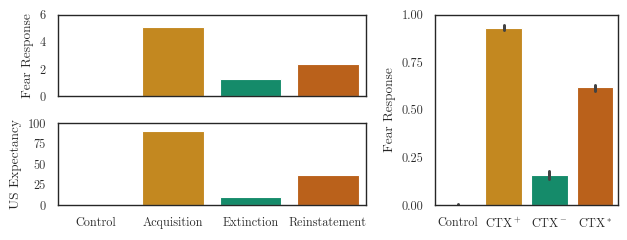

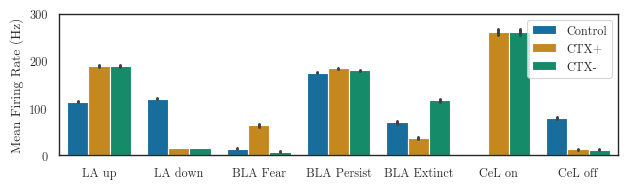

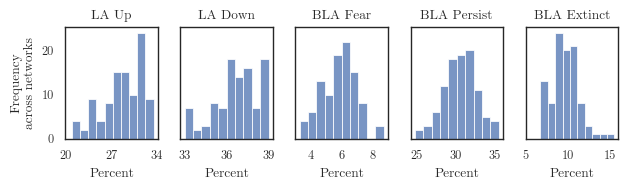

In [172]:
fear_expression_neural_responses(seeds=100, plot=False, load=True)

## Activation and Inactivation

In [67]:
def activation_inactivation(
        seeds=1,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        dim_CS=3,
        dim_CTX=5,
        nCS=1,
        nCTX=3,
        T_current=2,
        target="LA_pyr",
        stims=["Inactivate", "None", "Activate"],
        blocks=[
            "Control",
            "Acquisition",
            "Extinction",
            "CTX+",
            "CTX-"],
        load=False,
        plot=False,
    ):

    if load:
        data = pd.read_pickle(f"activation_{target}.pkl")    
    else:
        data = pd.DataFrame(columns=["seed", "Fear Response", "Stimulus", "Block", "Test"])
        rng = np.random.RandomState(seeds)

        for seed in range(seeds):
            lr1 = rng.uniform(2e-5, 4e-5)
            lr2 = rng.uniform(2e-4, 6e-4)
            lr3 = rng.uniform(8e-6, 2e-5)
            T_BLA_CS = rng.uniform(0.2, 0.4)
            T_BLA_CTX = rng.uniform(0.5, 1.0)
            for stim in stims:
                for block in blocks:
                    print(f"seed={seed}, target={target}, block={block}, stim={stim}")
                    net = build_network(seed=seed, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                        dt=dt, nNeurons=nNeurons, nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
                    with net:
                        if target=="LA_pyr":
                            nengo.Connection(net.applied_current, net.LA_pyr.neurons, transform=np.ones((2*nNeurons, 1)))
                        if target=="LA_inh":
                            nengo.Connection(net.applied_current, net.LA_inh.neurons, transform=np.ones((2*nNeurons, 1)))
                        if target=="BLA_pyr":
                            nengo.Connection(net.applied_current, net.BLA_pyr.neurons, transform=np.ones((3*nNeurons, 1)))
                        if target=="BLA_inh":
                            nengo.Connection(net.applied_current, net.BLA_inh.neurons, transform=np.ones((2*nNeurons, 1)))
                        if target=="CeL":
                            nengo.Connection(net.applied_current, net.CeL_on.neurons, transform=np.ones((nNeurons, 1)))
                            nengo.Connection(net.applied_current, net.CeL_off.neurons, transform=np.ones((nNeurons, 1)))
                        if target=="CeM":
                            nengo.Connection(net.applied_current, net.CeM.neurons, transform=np.ones((nNeurons, 1)))
                        net.pApplied = nengo.Probe(net.applied_current)
                    sim = nengo.Simulator(net, dt=dt, progress_bar=False)
                    with sim:
                        net.inputs.stop_learning = 0
                        print("control")
                        net.inputs.CS = net.inputs.CSs[0]
                        net.inputs.CTX = net.inputs.CTXs[0]
                        if block=="Control" and stim=="Activate":
                            net.inputs.applied_current = T_current
                        elif block=="Control" and stim=="Inactivate":
                            net.inputs.applied_current = -T_current
                        else:
                            net.inputs.applied_current = 0
                        sim.run(2)
                        T1a = int(1/dt)
                        T1b = int(2/dt)
                        print("conditioning")
                        net.inputs.CTX = net.inputs.CTXs[0]
                        net.inputs.US = 1
                        if block=="Acquisition" and stim=="Activate":
                            net.inputs.applied_current = T_current
                        elif block=="Acquisition" and stim=="Inactivate":
                            net.inputs.applied_current = -T_current
                        else:
                            net.inputs.applied_current = 0
                        for p in range(nCond):
                            sim.run(2)
                        T2a = int((2+2*nCond-1)/dt)
                        T2b = int((2+2*nCond-0.5)/dt)
                        print("extinction")
                        net.inputs.CTX = net.inputs.CTXs[1]
                        net.inputs.US = 0
                        if block=="Extinction" and stim=="Activate":
                            net.inputs.applied_current = T_current
                        elif block=="Extinction" and stim=="Inactivate":
                            net.inputs.applied_current = -T_current
                        else:
                            net.inputs.applied_current = 0
                        for p in range(nExt):
                            sim.run(2)
                        T3a = int((2+2*nCond+2*nExt-1)/dt)
                        T3b = int((2+2*nCond+2*nExt-0.5)/dt)
                        net.inputs.stop_learning = 1
                        print("test CTX A")
                        if block=="CTX+" and stim=="Activate":
                            net.inputs.applied_current = T_current
                        elif block=="CTX+" and stim=="Inactivate":
                            net.inputs.applied_current = -T_current
                        else:
                            net.inputs.applied_current = 0
                        net.inputs.CTX = net.inputs.CTXs[0]
                        net.inputs.US = 0
                        sim.run(2)
                        T4a = int((2+2*nCond+2*nExt+1)/dt)
                        T4b = int((2+2*nCond+2*nExt+1.5)/dt)
                        print("test CTX B")
                        if block=="CTX-" and stim=="Activate":
                            net.inputs.applied_current = T_current
                        elif block=="CTX-" and stim=="Inactivate":
                            net.inputs.applied_current = -T_current
                        else:
                            net.inputs.applied_current = 0
                        net.inputs.CTX = net.inputs.CTXs[1]
                        net.inputs.US = 0
                        sim.run(2)
                        T5a = int((2+2*nCond+2*nExt+2+1)/dt)
                        T5b = int((2+2*nCond+2*nExt+2+1.5)/dt)

                    if plot:
                        ctxA_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
                        ctxB_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[1])[0]
                        ctxC_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[2])[0]
                        ctx_signal = np.zeros((sim.trange().shape[0]))
                        ctx_signal2 = np.zeros((sim.trange().shape[0]))
                        ctx_signal[ctxB_idx] = 1
                        ctx_signal2[ctxC_idx] = 0.5
                        fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,2,4,4]})
                        axes[0].plot(sim.trange(), sim.data[net.pCeM])
                        axes[0].set(ylabel=r"$\hat{x}$", title="Fear Response", yticks=((0,1)))
                        axes[1].plot(sim.trange(), 1.4*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
                        axes[1].plot(sim.trange(), 1.8*sim.data[net.pUS], label="US", c='r')
                        axes[1].plot(sim.trange(), ctx_signal)
                        axes[1].plot(sim.trange(), ctx_signal2)
                        axes[1].set(yticks=((0,0.5,1,1.4,1.8)), yticklabels=(("CTX+","CTXn","CTX-","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
                        axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,0], label="BLA_pyr_CS")
                        axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,1], label="BLA_pyr_US")
                        axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,2], label="BLA_pyr_CTX")
                        axes[2].legend()
                        axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
                        axes[3].plot(sim.trange(), sim.data[net.pApplied], label="applied current")
                        axes[3].plot(sim.trange(), sim.data[net.pError_LA], label="CS minus US")
                        axes[3].plot(sim.trange(), sim.data[net.pError_BLA_safe], label="CS minus CTX")
                        axes[3].plot(sim.trange(), sim.data[net.pError_BLA_fear], label="US minus CTX")
                        axes[3].legend()
                        axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
                        plt.tight_layout()
                    
                    data = data.append({"seed": seed, "Test" :"Baseline", "Fear Response": np.mean(sim.data[net.pCeM][T1a: T1b]), "Stimulus": stim, "Block": block},ignore_index=True)
                    data = data.append({"seed": seed, "Test" :"CTX+", "Fear Response": np.mean(sim.data[net.pCeM][T4a: T4b]), "Stimulus": stim, "Block": block}, ignore_index=True)
                    data = data.append({"seed": seed, "Test" :"CTX-", "Fear Response": np.mean(sim.data[net.pCeM][T5a: T5b]), "Stimulus": stim, "Block": block}, ignore_index=True)
                    
        data.to_pickle(f"activation_{target}.pkl")

#     fig, axes = plt.subplots(nrows=3, ncols=1, figsize=((6.38, 4)), sharex=True)
#     bar1 = sns.barplot(data=data.query("Stimulus=='Inactivate'"), x='Block', y='Fear Response', hue="Test", ax=axes[0])
#     bar2 = sns.barplot(data=data.query("Stimulus=='None'"), x='Block', y='Fear Response', hue="Test", ax=axes[1])
#     bar3 = sns.barplot(data=data.query("Stimulus=='Activate'"),x='Block', y='Fear Response', hue="Test", ax=axes[2])
#     axes[0].set(ylabel="Inhibition", yticks=((0, 0.5, 1.0)), ylim=((0, 1.1)), xlabel=None)
#     axes[1].set(ylabel="Baseline", yticks=((0, 0.5, 1.0)), ylim=((0, 1.1)), xlabel=None)
#     axes[2].set(ylabel="Activation", yticks=((0, 0.5, 1.0)), ylim=((0, 1.1)), xlabel="External Current Applied During")
#     axes[0].get_legend().remove()
#     axes[2].get_legend().remove()
#     plt.tight_layout()
#     fig.savefig(f"activation_inactivation_{target}.png", dpi=600)
#     fig.savefig(f"activation_inactivation_{target}.svg")

In [68]:
activation_inactivation(seeds=10, stims=["None", "Inactivate"], target="LA_pyr")

seed=0, target=LA_pyr, block=Control, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=Acquisition, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=Extinction, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=CTX+, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=CTX-, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=CTX-, stim=Inactivate
co

test CTX B
seed=7, target=LA_pyr, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=7, target=LA_pyr, block=CTX-, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=Control, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=Acquisition, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=Extinction, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=CTX+, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=CTX-, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=Extinction, stim=In

In [69]:
activation_inactivation(seeds=10, stims=["Inactivate"], target="LA_inh")

seed=0, target=LA_inh, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_inh, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_inh, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_inh, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_inh, block=CTX-, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=LA_inh, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=LA_inh, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=LA_inh, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=LA_inh, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=LA_inh, 

In [70]:
activation_inactivation(seeds=10, stims=["Inactivate"], target="BLA_pyr")

seed=0, target=BLA_pyr, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_pyr, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_pyr, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_pyr, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_pyr, block=CTX-, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_pyr, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_pyr, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_pyr, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_pyr, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target

In [71]:
activation_inactivation(seeds=10, stims=["Inactivate"], target="BLA_inh")

seed=0, target=BLA_inh, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_inh, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_inh, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_inh, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_inh, block=CTX-, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_inh, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_inh, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_inh, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_inh, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target

In [72]:
activation_inactivation(seeds=10, stims=["Inactivate"], target="CeL")

seed=0, target=CeL, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeL, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeL, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeL, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeL, block=CTX-, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeL, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeL, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeL, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeL, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeL, block=CTX-, stim=Inactivate
co

In [73]:
activation_inactivation(seeds=10, stims=["Inactivate"], target="CeM")

seed=0, target=CeM, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeM, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeM, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeM, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeM, block=CTX-, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeM, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeM, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeM, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeM, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeM, block=CTX-, stim=Inactivate
co

### replot inactivaiton data

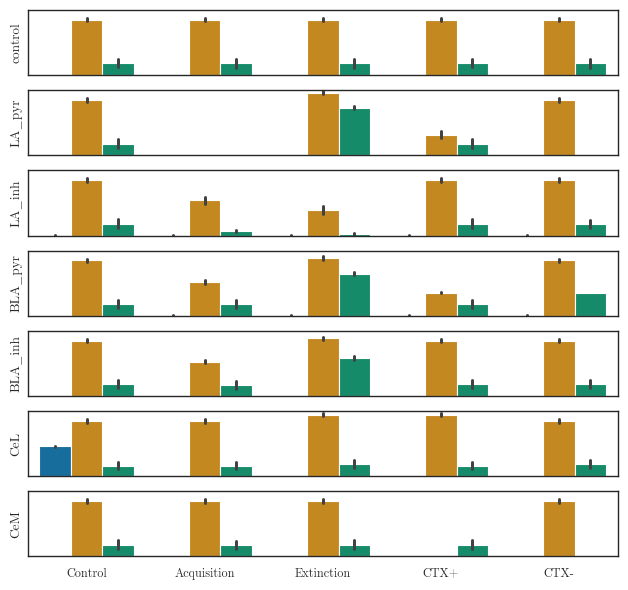

In [77]:
targets = ["LA_pyr", "LA_inh", "BLA_pyr", "BLA_inh", "CeL", "CeM"]
fig, axes = plt.subplots(nrows=len(targets)+1, ncols=1, sharex=True, figsize=((6.38, 6)))

data = pd.read_pickle(f"activation_LA_pyr.pkl").query("Stimulus=='None'")
sns.barplot(data=data, x='Block', y='Fear Response', hue="Test", ax=axes[0], palette=palette)
axes[0].set(ylabel="control", yticks=(()), ylim=((0, 1.1)), xlabel=None)
axes[0].get_legend().remove()

for i, target in enumerate(targets):
    data = pd.read_pickle(f"activation_{target}.pkl").query("Stimulus=='Inactivate'")
    sns.barplot(data=data, x='Block', y='Fear Response', hue="Test", ax=axes[i+1], palette=palette)
    axes[i+1].set(ylabel=target, yticks=(()), ylim=((0, 1.1)), xlabel=None)
    axes[i+1].get_legend().remove()

plt.tight_layout()
# fig.savefig(f"inactivation_combined.png", dpi=600)
fig.savefig(f"inactivation3.svg")

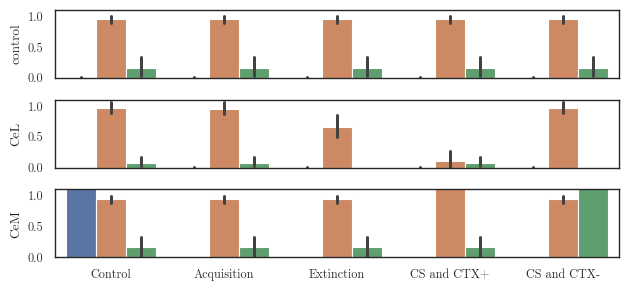

In [129]:
# targets = ["LA_pyr", "LA_inh", "BLA_pyr", "BLA_inh", "CeL", "CeM"]
targets = ["CeL", "CeM"]
fig, axes = plt.subplots(nrows=len(targets)+1, ncols=1, sharex=True, figsize=((6.38, 3)))

data = pd.read_pickle(f"activation_LA_pyr.pkl").query("Stimulus=='None'")
sns.barplot(data=data, x='Block', y='Fear Response', hue="Test", ax=axes[0])
axes[0].set(ylabel="control", yticks=((0, 0.5, 1.0)), ylim=((0, 1.1)), xlabel=None)
axes[0].get_legend().remove()

for i, target in enumerate(targets):
    data = pd.read_pickle(f"activation_{target}.pkl").query("Stimulus=='Activate'")
    sns.barplot(data=data, x='Block', y='Fear Response', hue="Test", ax=axes[i+1])
    axes[i+1].set(ylabel=target, yticks=((0, 0.5, 1.0)), ylim=((0, 1.1)), xlabel=None)
    axes[i+1].get_legend().remove()

plt.tight_layout()
fig.savefig(f"activation_combined.png", dpi=600)
fig.savefig(f"activation_combined.svg")

## Fear Generalization

In [25]:
def generalization(
        experiment,
        seeds=1,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        nCS=1,
        nCTX=2,
        dim_CS=3,
        dim_CTX=5,
        intercept_CS=0,
        intercept_CTX=0,
        load=False,
        style="line",
    ):

    if load:
        if experiment=="CS":
            data = pd.read_pickle(f"generalization_{experiment}_intercept{intercept_CS}.pkl")
        if experiment=="CTX":
            data = pd.read_pickle(f"generalization_{experiment}_intercept{intercept_CTX}.pkl")
        if experiment=="CS+CTX":
            data = pd.read_pickle(f"generalization_{experiment}_intercept{intercept_CTX}.pkl")

    else:
        rng = np.random.RandomState(seeds)
        if experiment=="CS":
            data = pd.DataFrame(columns=["seed", "Fear Response", "Similarity to CS+"])
        elif experiment=="CTX" or experiment=="CS+CTX":
            data = pd.DataFrame(columns=["seed", "Fear Response", "Similarity to CTX+", "Similarity to CTX-"])
        for seed in range(seeds):
            print(f"seed={seed}")
            lr1 = rng.uniform(2e-5, 4e-5)
            lr2 = rng.uniform(2e-4, 6e-4)
            lr3 = rng.uniform(8e-6, 2e-5)
            T_BLA_CS = rng.uniform(0.2, 0.4)
            T_BLA_CTX = rng.uniform(0.5, 1.0)
            net = build_network(
                seed=seed, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                intercept_CS=intercept_CS, intercept_CTX=intercept_CTX,
                dt=dt, nNeurons=nNeurons,
                nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
            sim = nengo.Simulator(net, dt=dt, progress_bar=False)
            CTXplus = net.inputs.CTXs[0]
            CSplus = net.inputs.CSs[0]
            CTXsim = np.dot(CTXplus, net.inputs.CTXs.T)
            CTXminus = net.inputs.CTXs[np.argmin(CTXsim)]
            with sim:
                print("acquisition")
                net.inputs.stop_learning = 0
                net.inputs.US = 1
                net.inputs.CS = CSplus
                net.inputs.CTX = CTXplus
                for p in range(nCond):
                    sim.run(2)
                print("extinction")
                net.inputs.CS = 0
                net.inputs.US = 0
                net.inputs.CTX = CTXminus
                for p in range(nExt):
                    sim.run(2)
                print("testing")
                net.inputs.stop_learning = 1
                net.inputs.US = 0
                if experiment=="CS":
                    for cs in range(nCS):
                        print(f"CS {cs}")
                        CS = net.inputs.CSs[cs]
                        net.inputs.CS = CS
                        net.inputs.CTX = CTXplus
                        sim.run(2)
                        freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                        similarity = np.dot(CSplus, CS)
                        data = data.append({
                            "seed": int(seed),
                            "Fear Response": freezing,
                            "Similarity to CS+": np.around(similarity, 3),
                        }, ignore_index=True)
                elif experiment=="CTX":
                    for ctx in range(nCTX):
                        print(f"CTX {ctx}")
                        CTX = net.inputs.CTXs[ctx]
                        net.inputs.CTX = CTX
                        net.inputs.CS = 0
                        net.inputs.US = 0
                        sim.run(2)
                        freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                        similarity_plus = np.dot(CTXplus, CTX)
                        similarity_minus = np.dot(CTXminus, CTX)
                        data = data.append({
                            "seed": int(seed),
                            "Fear Response": freezing,
                            "Similarity to CTX+": np.around(similarity_plus, 3),
                            "Similarity to CTX-": np.around(similarity_minus, 3),
                        }, ignore_index=True)
                elif experiment=="CS+CTX":
                    for ctx in range(nCTX):
                        print(f"CTX {ctx}")
                        CTX = net.inputs.CTXs[ctx]
                        net.inputs.CTX = CTX
                        net.inputs.CS = CSplus
                        net.inputs.US = 0
                        sim.run(2)
                        freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                        similarity_plus = np.dot(CTXplus, CTX)
                        similarity_minus = np.dot(CTXminus, CTX)
                        data = data.append({
                            "seed": int(seed),
                            "Fear Response": freezing,
                            "Similarity to CTX+": np.around(similarity_plus, 3),
                            "Similarity to CTX-": np.around(similarity_minus, 3),
                        }, ignore_index=True)

    if experiment=="CS":
        data.to_pickle(f"generalization_{experiment}_intercept{intercept_CS}.pkl")
    if experiment=="CTX":
        data.to_pickle(f"generalization_{experiment}_intercept{intercept_CTX}.pkl")
    if experiment=="CS+CTX":
        data.to_pickle(f"generalization_{experiment}_intercept{intercept_CTX}.pkl")

### CS Generalization

In [24]:
generalization(experiment="CS", seeds=10, nCS=100, intercept_CS=0.8, load=False)

seed=0
acquisition
extinction
testing
CS 0
CS 1
CS 2
CS 3
CS 4
CS 5
CS 6
CS 7
CS 8
CS 9
CS 10
CS 11
CS 12
CS 13
CS 14
CS 15
CS 16
CS 17
CS 18
CS 19
CS 20
CS 21
CS 22
CS 23
CS 24
CS 25
CS 26
CS 27
CS 28
CS 29
CS 30
CS 31
CS 32
CS 33
CS 34
CS 35
CS 36
CS 37
CS 38
CS 39
CS 40
CS 41
CS 42
CS 43
CS 44
CS 45
CS 46
CS 47
CS 48
CS 49
CS 50
CS 51
CS 52
CS 53
CS 54
CS 55
CS 56
CS 57
CS 58
CS 59
CS 60
CS 61
CS 62
CS 63
CS 64
CS 65
CS 66
CS 67
CS 68
CS 69
CS 70
CS 71
CS 72
CS 73
CS 74
CS 75
CS 76
CS 77
CS 78
CS 79
CS 80
CS 81
CS 82
CS 83
CS 84
CS 85
CS 86
CS 87
CS 88
CS 89
CS 90
CS 91
CS 92
CS 93
CS 94
CS 95
CS 96
CS 97
CS 98
CS 99
seed=1
acquisition
extinction
testing
CS 0
CS 1
CS 2
CS 3
CS 4
CS 5
CS 6
CS 7
CS 8
CS 9
CS 10
CS 11
CS 12
CS 13
CS 14
CS 15
CS 16
CS 17
CS 18
CS 19
CS 20
CS 21
CS 22
CS 23
CS 24
CS 25
CS 26
CS 27
CS 28
CS 29
CS 30
CS 31
CS 32
CS 33
CS 34
CS 35
CS 36
CS 37
CS 38
CS 39
CS 40
CS 41
CS 42
CS 43
CS 44
CS 45
CS 46
CS 47
CS 48
CS 49
CS 50
CS 51
CS 52
CS 53
CS 54
CS 55
CS 56
CS

In [25]:
generalization(experiment="CS", seeds=10, nCS=100, intercept_CS=0.6, load=False)

seed=0
acquisition
extinction
testing
CS 0
CS 1
CS 2
CS 3
CS 4
CS 5
CS 6
CS 7
CS 8
CS 9
CS 10
CS 11
CS 12
CS 13
CS 14
CS 15
CS 16
CS 17
CS 18
CS 19
CS 20
CS 21
CS 22
CS 23
CS 24
CS 25
CS 26
CS 27
CS 28
CS 29
CS 30
CS 31
CS 32
CS 33
CS 34
CS 35
CS 36
CS 37
CS 38
CS 39
CS 40
CS 41
CS 42
CS 43
CS 44
CS 45
CS 46
CS 47
CS 48
CS 49
CS 50
CS 51
CS 52
CS 53
CS 54
CS 55
CS 56
CS 57
CS 58
CS 59
CS 60
CS 61
CS 62
CS 63
CS 64
CS 65
CS 66
CS 67
CS 68
CS 69
CS 70
CS 71
CS 72
CS 73
CS 74
CS 75
CS 76
CS 77
CS 78
CS 79
CS 80
CS 81
CS 82
CS 83
CS 84
CS 85
CS 86
CS 87
CS 88
CS 89
CS 90
CS 91
CS 92
CS 93
CS 94
CS 95
CS 96
CS 97
CS 98
CS 99
seed=1
acquisition
extinction
testing
CS 0
CS 1
CS 2
CS 3
CS 4
CS 5
CS 6
CS 7
CS 8
CS 9
CS 10
CS 11
CS 12
CS 13
CS 14
CS 15
CS 16
CS 17
CS 18
CS 19
CS 20
CS 21
CS 22
CS 23
CS 24
CS 25
CS 26
CS 27
CS 28
CS 29
CS 30
CS 31
CS 32
CS 33
CS 34
CS 35
CS 36
CS 37
CS 38
CS 39
CS 40
CS 41
CS 42
CS 43
CS 44
CS 45
CS 46
CS 47
CS 48
CS 49
CS 50
CS 51
CS 52
CS 53
CS 54
CS 55
CS 56
CS

In [26]:
generalization(experiment="CS", seeds=10, nCS=100, intercept_CS=0.4, load=False)

seed=0
acquisition
extinction
testing
CS 0
CS 1
CS 2
CS 3
CS 4
CS 5
CS 6
CS 7
CS 8
CS 9
CS 10
CS 11
CS 12
CS 13
CS 14
CS 15
CS 16
CS 17
CS 18
CS 19
CS 20
CS 21
CS 22
CS 23
CS 24
CS 25
CS 26
CS 27
CS 28
CS 29
CS 30
CS 31
CS 32
CS 33
CS 34
CS 35
CS 36
CS 37
CS 38
CS 39
CS 40
CS 41
CS 42
CS 43
CS 44
CS 45
CS 46
CS 47
CS 48
CS 49
CS 50
CS 51
CS 52
CS 53
CS 54
CS 55
CS 56
CS 57
CS 58
CS 59
CS 60
CS 61
CS 62
CS 63
CS 64
CS 65
CS 66
CS 67
CS 68
CS 69
CS 70
CS 71
CS 72
CS 73
CS 74
CS 75
CS 76
CS 77
CS 78
CS 79
CS 80
CS 81
CS 82
CS 83
CS 84
CS 85
CS 86
CS 87
CS 88
CS 89
CS 90
CS 91
CS 92
CS 93
CS 94
CS 95
CS 96
CS 97
CS 98
CS 99
seed=1
acquisition
extinction
testing
CS 0
CS 1
CS 2
CS 3
CS 4
CS 5
CS 6
CS 7
CS 8
CS 9
CS 10
CS 11
CS 12
CS 13
CS 14
CS 15
CS 16
CS 17
CS 18
CS 19
CS 20
CS 21
CS 22
CS 23
CS 24
CS 25
CS 26
CS 27
CS 28
CS 29
CS 30
CS 31
CS 32
CS 33
CS 34
CS 35
CS 36
CS 37
CS 38
CS 39
CS 40
CS 41
CS 42
CS 43
CS 44
CS 45
CS 46
CS 47
CS 48
CS 49
CS 50
CS 51
CS 52
CS 53
CS 54
CS 55
CS 56
CS

In [53]:
generalization(experiment="CS", seeds=10, nCS=100, intercept_CS=0.0, load=False)

seed=0


/home/pduggins/amygdala/.venv/lib/python3.7/site-packages/nengo/cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


acquisition
extinction
testing
CS 0
CS 1
CS 2
CS 3
CS 4
CS 5
CS 6
CS 7
CS 8
CS 9
CS 10
CS 11
CS 12
CS 13
CS 14
CS 15
CS 16
CS 17
CS 18
CS 19
CS 20
CS 21
CS 22
CS 23
CS 24
CS 25
CS 26
CS 27
CS 28
CS 29
CS 30
CS 31
CS 32
CS 33
CS 34
CS 35
CS 36
CS 37
CS 38
CS 39
CS 40
CS 41
CS 42
CS 43
CS 44
CS 45
CS 46
CS 47
CS 48
CS 49
CS 50
CS 51
CS 52
CS 53
CS 54
CS 55
CS 56
CS 57
CS 58
CS 59
CS 60
CS 61
CS 62
CS 63
CS 64
CS 65
CS 66
CS 67
CS 68
CS 69
CS 70
CS 71
CS 72
CS 73
CS 74
CS 75
CS 76
CS 77
CS 78
CS 79
CS 80
CS 81
CS 82
CS 83
CS 84
CS 85
CS 86
CS 87
CS 88
CS 89
CS 90
CS 91
CS 92
CS 93
CS 94
CS 95
CS 96
CS 97
CS 98
CS 99
seed=1
acquisition
extinction
testing
CS 0
CS 1
CS 2
CS 3
CS 4
CS 5
CS 6
CS 7
CS 8
CS 9
CS 10
CS 11
CS 12
CS 13
CS 14
CS 15
CS 16
CS 17
CS 18
CS 19
CS 20
CS 21
CS 22
CS 23
CS 24
CS 25
CS 26
CS 27
CS 28
CS 29
CS 30
CS 31
CS 32
CS 33
CS 34
CS 35
CS 36
CS 37
CS 38
CS 39
CS 40
CS 41
CS 42
CS 43
CS 44
CS 45
CS 46
CS 47
CS 48
CS 49
CS 50
CS 51
CS 52
CS 53
CS 54
CS 55
CS 56
CS 57
CS 

seed=0
acquisition
extinction
testing
CS 0
CS 1
CS 2
CS 3
CS 4
CS 5
CS 6
CS 7
CS 8
CS 9
CS 10
CS 11
CS 12
CS 13
CS 14
CS 15
CS 16
CS 17
CS 18
CS 19
CS 20
CS 21
CS 22
CS 23
CS 24
CS 25
CS 26
CS 27
CS 28
CS 29
CS 30
CS 31
CS 32
CS 33
CS 34
CS 35
CS 36
CS 37
CS 38
CS 39
CS 40
CS 41
CS 42
CS 43
CS 44
CS 45
CS 46
CS 47
CS 48
CS 49
CS 50
CS 51
CS 52
CS 53
CS 54
CS 55
CS 56
CS 57
CS 58
CS 59
CS 60
CS 61
CS 62
CS 63
CS 64
CS 65
CS 66
CS 67
CS 68
CS 69
CS 70
CS 71
CS 72
CS 73
CS 74
CS 75
CS 76
CS 77
CS 78
CS 79
CS 80
CS 81
CS 82
CS 83
CS 84
CS 85
CS 86
CS 87
CS 88
CS 89
CS 90
CS 91
CS 92
CS 93
CS 94
CS 95
CS 96
CS 97
CS 98
CS 99


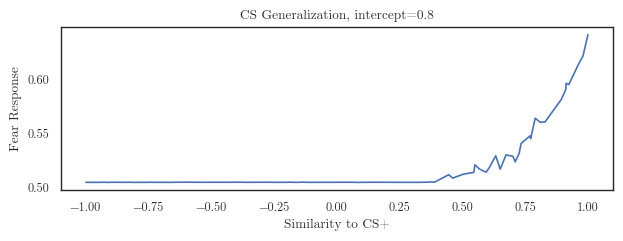

In [24]:
generalization(experiment="CS", seeds=1, nCS=100, intercept_CS=0.8, load=False, nCond=10)

### CTX Generalization

In [27]:
generalization(experiment="CTX", seeds=10, nCTX=100, intercept_CTX=0.6, load=False)

seed=0
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9
CTX 10
CTX 11
CTX 12
CTX 13
CTX 14
CTX 15
CTX 16
CTX 17
CTX 18
CTX 19
CTX 20
CTX 21
CTX 22
CTX 23
CTX 24
CTX 25
CTX 26
CTX 27
CTX 28
CTX 29
CTX 30
CTX 31
CTX 32
CTX 33
CTX 34
CTX 35
CTX 36
CTX 37
CTX 38
CTX 39
CTX 40
CTX 41
CTX 42
CTX 43
CTX 44
CTX 45
CTX 46
CTX 47
CTX 48
CTX 49
CTX 50
CTX 51
CTX 52
CTX 53
CTX 54
CTX 55
CTX 56
CTX 57
CTX 58
CTX 59
CTX 60
CTX 61
CTX 62
CTX 63
CTX 64
CTX 65
CTX 66
CTX 67
CTX 68
CTX 69
CTX 70
CTX 71
CTX 72
CTX 73
CTX 74
CTX 75
CTX 76
CTX 77
CTX 78
CTX 79
CTX 80
CTX 81
CTX 82
CTX 83
CTX 84
CTX 85
CTX 86
CTX 87
CTX 88
CTX 89
CTX 90
CTX 91
CTX 92
CTX 93
CTX 94
CTX 95
CTX 96
CTX 97
CTX 98
CTX 99
seed=1
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9
CTX 10
CTX 11
CTX 12
CTX 13
CTX 14
CTX 15
CTX 16
CTX 17
CTX 18
CTX 19
CTX 20
CTX 21
CTX 22
CTX 23
CTX 24
CTX 25
CTX 26
CTX 27
CTX 28
CTX 29
CTX 30
CTX 31
CTX 32
CTX 33
CTX 34

In [28]:
generalization(experiment="CTX", seeds=10, nCTX=100, intercept_CTX=0.3, load=False)

seed=0
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9
CTX 10
CTX 11
CTX 12
CTX 13
CTX 14
CTX 15
CTX 16
CTX 17
CTX 18
CTX 19
CTX 20
CTX 21
CTX 22
CTX 23
CTX 24
CTX 25
CTX 26
CTX 27
CTX 28
CTX 29
CTX 30
CTX 31
CTX 32
CTX 33
CTX 34
CTX 35
CTX 36
CTX 37
CTX 38
CTX 39
CTX 40
CTX 41
CTX 42
CTX 43
CTX 44
CTX 45
CTX 46
CTX 47
CTX 48
CTX 49
CTX 50
CTX 51
CTX 52
CTX 53
CTX 54
CTX 55
CTX 56
CTX 57
CTX 58
CTX 59
CTX 60
CTX 61
CTX 62
CTX 63
CTX 64
CTX 65
CTX 66
CTX 67
CTX 68
CTX 69
CTX 70
CTX 71
CTX 72
CTX 73
CTX 74
CTX 75
CTX 76
CTX 77
CTX 78
CTX 79
CTX 80
CTX 81
CTX 82
CTX 83
CTX 84
CTX 85
CTX 86
CTX 87
CTX 88
CTX 89
CTX 90
CTX 91
CTX 92
CTX 93
CTX 94
CTX 95
CTX 96
CTX 97
CTX 98
CTX 99
seed=1
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9
CTX 10
CTX 11
CTX 12
CTX 13
CTX 14
CTX 15
CTX 16
CTX 17
CTX 18
CTX 19
CTX 20
CTX 21
CTX 22
CTX 23
CTX 24
CTX 25
CTX 26
CTX 27
CTX 28
CTX 29
CTX 30
CTX 31
CTX 32
CTX 33
CTX 34

In [29]:
generalization(experiment="CTX", seeds=10, nCTX=100, intercept_CTX=0.0, load=False)

seed=0
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9
CTX 10
CTX 11
CTX 12
CTX 13
CTX 14
CTX 15
CTX 16
CTX 17
CTX 18
CTX 19
CTX 20
CTX 21
CTX 22
CTX 23
CTX 24
CTX 25
CTX 26
CTX 27
CTX 28
CTX 29
CTX 30
CTX 31
CTX 32
CTX 33
CTX 34
CTX 35
CTX 36
CTX 37
CTX 38
CTX 39
CTX 40
CTX 41
CTX 42
CTX 43
CTX 44
CTX 45
CTX 46
CTX 47
CTX 48
CTX 49
CTX 50
CTX 51
CTX 52
CTX 53
CTX 54
CTX 55
CTX 56
CTX 57
CTX 58
CTX 59
CTX 60
CTX 61
CTX 62
CTX 63
CTX 64
CTX 65
CTX 66
CTX 67
CTX 68
CTX 69
CTX 70
CTX 71
CTX 72
CTX 73
CTX 74
CTX 75
CTX 76
CTX 77
CTX 78
CTX 79
CTX 80
CTX 81
CTX 82
CTX 83
CTX 84
CTX 85
CTX 86
CTX 87
CTX 88
CTX 89
CTX 90
CTX 91
CTX 92
CTX 93
CTX 94
CTX 95
CTX 96
CTX 97
CTX 98
CTX 99
seed=1
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9
CTX 10
CTX 11
CTX 12
CTX 13
CTX 14
CTX 15
CTX 16
CTX 17
CTX 18
CTX 19
CTX 20
CTX 21
CTX 22
CTX 23
CTX 24
CTX 25
CTX 26
CTX 27
CTX 28
CTX 29
CTX 30
CTX 31
CTX 32
CTX 33
CTX 34

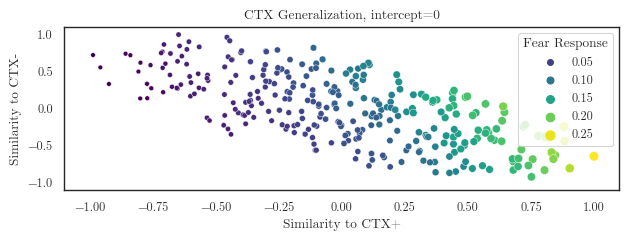

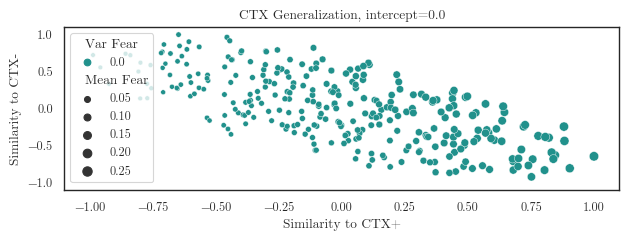

In [67]:
generalization(experiment="CTX", seeds=1, nCTX=300, intercept_CTX=0.0, load=True)

### CS+CTX Generalization

In [30]:
generalization(experiment="CS+CTX", seeds=10, nCTX=100, intercept_CTX=0.0, intercept_CS=0.0, load=False)

seed=0
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9
CTX 10
CTX 11
CTX 12
CTX 13
CTX 14
CTX 15
CTX 16
CTX 17
CTX 18
CTX 19
CTX 20
CTX 21
CTX 22
CTX 23
CTX 24
CTX 25
CTX 26
CTX 27
CTX 28
CTX 29
CTX 30
CTX 31
CTX 32
CTX 33
CTX 34
CTX 35
CTX 36
CTX 37
CTX 38
CTX 39
CTX 40
CTX 41
CTX 42
CTX 43
CTX 44
CTX 45
CTX 46
CTX 47
CTX 48
CTX 49
CTX 50
CTX 51
CTX 52
CTX 53
CTX 54
CTX 55
CTX 56
CTX 57
CTX 58
CTX 59
CTX 60
CTX 61
CTX 62
CTX 63
CTX 64
CTX 65
CTX 66
CTX 67
CTX 68
CTX 69
CTX 70
CTX 71
CTX 72
CTX 73
CTX 74
CTX 75
CTX 76
CTX 77
CTX 78
CTX 79
CTX 80
CTX 81
CTX 82
CTX 83
CTX 84
CTX 85
CTX 86
CTX 87
CTX 88
CTX 89
CTX 90
CTX 91
CTX 92
CTX 93
CTX 94
CTX 95
CTX 96
CTX 97
CTX 98
CTX 99
seed=1
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9
CTX 10
CTX 11
CTX 12
CTX 13
CTX 14
CTX 15
CTX 16
CTX 17
CTX 18
CTX 19
CTX 20
CTX 21
CTX 22
CTX 23
CTX 24
CTX 25
CTX 26
CTX 27
CTX 28
CTX 29
CTX 30
CTX 31
CTX 32
CTX 33
CTX 34

In [31]:
generalization(experiment="CS+CTX", seeds=10, nCTX=100, intercept_CTX=0.25, intercept_CS=0.0, load=False)

seed=0
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9
CTX 10
CTX 11
CTX 12
CTX 13
CTX 14
CTX 15
CTX 16
CTX 17
CTX 18
CTX 19
CTX 20
CTX 21
CTX 22
CTX 23
CTX 24
CTX 25
CTX 26
CTX 27
CTX 28
CTX 29
CTX 30
CTX 31
CTX 32
CTX 33
CTX 34
CTX 35
CTX 36
CTX 37
CTX 38
CTX 39
CTX 40
CTX 41
CTX 42
CTX 43
CTX 44
CTX 45
CTX 46
CTX 47
CTX 48
CTX 49
CTX 50
CTX 51
CTX 52
CTX 53
CTX 54
CTX 55
CTX 56
CTX 57
CTX 58
CTX 59
CTX 60
CTX 61
CTX 62
CTX 63
CTX 64
CTX 65
CTX 66
CTX 67
CTX 68
CTX 69
CTX 70
CTX 71
CTX 72
CTX 73
CTX 74
CTX 75
CTX 76
CTX 77
CTX 78
CTX 79
CTX 80
CTX 81
CTX 82
CTX 83
CTX 84
CTX 85
CTX 86
CTX 87
CTX 88
CTX 89
CTX 90
CTX 91
CTX 92
CTX 93
CTX 94
CTX 95
CTX 96
CTX 97
CTX 98
CTX 99
seed=1
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9
CTX 10
CTX 11
CTX 12
CTX 13
CTX 14
CTX 15
CTX 16
CTX 17
CTX 18
CTX 19
CTX 20
CTX 21
CTX 22
CTX 23
CTX 24
CTX 25
CTX 26
CTX 27
CTX 28
CTX 29
CTX 30
CTX 31
CTX 32
CTX 33
CTX 34

In [32]:
generalization(experiment="CS+CTX", seeds=10, nCTX=100, intercept_CTX=0.5, intercept_CS=0.0, load=False)

seed=0
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9
CTX 10
CTX 11
CTX 12
CTX 13
CTX 14
CTX 15
CTX 16
CTX 17
CTX 18
CTX 19
CTX 20
CTX 21
CTX 22
CTX 23
CTX 24
CTX 25
CTX 26
CTX 27
CTX 28
CTX 29
CTX 30
CTX 31
CTX 32
CTX 33
CTX 34
CTX 35
CTX 36
CTX 37
CTX 38
CTX 39
CTX 40
CTX 41
CTX 42
CTX 43
CTX 44
CTX 45
CTX 46
CTX 47
CTX 48
CTX 49
CTX 50
CTX 51
CTX 52
CTX 53
CTX 54
CTX 55
CTX 56
CTX 57
CTX 58
CTX 59
CTX 60
CTX 61
CTX 62
CTX 63
CTX 64
CTX 65
CTX 66
CTX 67
CTX 68
CTX 69
CTX 70
CTX 71
CTX 72
CTX 73
CTX 74
CTX 75
CTX 76
CTX 77
CTX 78
CTX 79
CTX 80
CTX 81
CTX 82
CTX 83
CTX 84
CTX 85
CTX 86
CTX 87
CTX 88
CTX 89
CTX 90
CTX 91
CTX 92
CTX 93
CTX 94
CTX 95
CTX 96
CTX 97
CTX 98
CTX 99
seed=1
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9
CTX 10
CTX 11
CTX 12
CTX 13
CTX 14
CTX 15
CTX 16
CTX 17
CTX 18
CTX 19
CTX 20
CTX 21
CTX 22
CTX 23
CTX 24
CTX 25
CTX 26
CTX 27
CTX 28
CTX 29
CTX 30
CTX 31
CTX 32
CTX 33
CTX 34

### Combine Lissek Data and Simulated Generalization

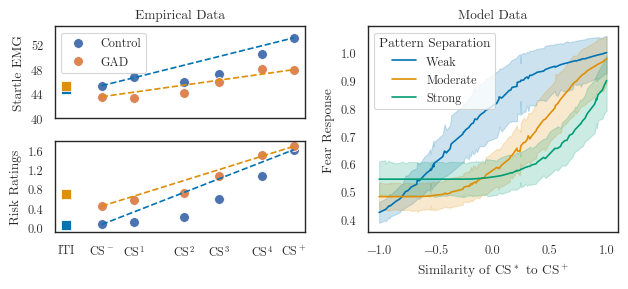

In [91]:
fig = plt.figure(figsize=((6.38, 3)))
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,0))    
ax3 = plt.subplot2grid((2,2), (0,1), rowspan=2)

xs = [2.0, 2.45, 3.15, 3.65, 4.25, 4.7]
xITI = [1.5]
# xtickExtra = ["\nCS-", "\nCS1", "\nCS2", "\nCS3", "\nCS4", "\nCS+"]
# xticklabels = ['\nITI'] + [str(xs[i]) + xtickExtra[i] for i in range(len(xs))]
xtickExtra = [r"CS$^-$", r"CS$^1$", r"CS$^2$", r"CS$^3$", r"CS$^4$", r"CS$^+$"]
xticklabels = ['ITI'] + [xtickExtra[i] for i in range(len(xs))]

# startle response, healthy controls
ys = [45.29, 46.64, 45.89, 47.24, 50.56, 53.13]
yITI = [44.76]
sns.scatterplot(x=xs, y=ys, ax=ax1, s=50, label="Control")
sns.scatterplot(x=xITI, y=yITI, ax=ax1, s=50, color=palette[0], label=None, marker='s')
sns.lineplot(x=[xs[0], xs[-1]], y=[ys[0], ys[-1]], ax=ax1, linestyle="--", color=palette[0])
ax1.set(xlabel=None, ylabel="Startle EMG", title="Empirical Data", # \n(T-score)
      ylim=((40, 55)), yticks=((40, 44, 48, 52)), xticks=(()))

# risk ratings, healthy controls
ys = [0.06, 0.12, 0.21, 0.58, 1.07, 1.61]
yITI = [0.04]
sns.scatterplot(x=xs, y=ys, ax=ax2, s=50, label="Control")
sns.scatterplot(x=xITI, y=yITI, ax=ax2, s=50, color=palette[0], label=None, marker='s')
sns.lineplot(x=[xs[0], xs[-1]], y=[ys[0], ys[-1]], ax=ax2, linestyle="--", color=palette[0])
ax2.set(xlabel=None, ylabel="Risk Ratings",
      ylim=((-0.1, 1.8)), yticks=((0, 0.4, 0.8, 1.2, 1.6)), xticks=(()))

# startle response, GAD
ys = [43.49, 43.22, 44.11, 45.89, 48.03, 47.92]
yITI = [45.25]
sns.scatterplot(x=xs, y=ys, ax=ax1, s=50, label="GAD")
sns.scatterplot(x=xITI, y=yITI, ax=ax1, s=50, color=palette[1], label=None, marker='s')
sns.lineplot(x=[xs[0], xs[-1]], y=[ys[0], ys[-1]], ax=ax1, linestyle="--", color=palette[1])
ax1.set(ylabel="Startle EMG", xlabel=None, # \n(T-score)
      ylim=((40, 55)), yticks=((40, 44, 48, 52)), xticks=(()))

# risk ratings, GAD
ys = [0.44, 0.56, 0.72, 1.07, 1.51, 1.68]
yITI = [0.70]
sns.scatterplot(x=xs, y=ys, ax=ax2, s=50, label="GAD")
sns.scatterplot(x=xITI, y=yITI, ax=ax2, s=50, color=palette[1], label=None, marker='s')
sns.lineplot(x=[xs[0], xs[-1]], y=[ys[0], ys[-1]], ax=ax2, linestyle="--", color=palette[1])
ax2.set(ylabel="Risk Ratings", xlabel="Test Stimulus",
      ylim=((-0.1, 1.8)), yticks=((0, 0.4, 0.8, 1.2, 1.6)), xticks=xITI+xs, xticklabels=xticklabels)

ax2.get_legend().remove()

for i, intercept in enumerate(intercepts):
    data = pd.read_pickle(f"generalization_CS_intercept{intercept}.pkl")
    if intercept==0.0: label="Weak"
    if intercept==0.4: label="Moderate"
    if intercept==0.6: label="Strong"
    sns.lineplot(data=data, x='Similarity to CS+', y="Fear Response",
        ax=ax3, color=palette[i], label=label)

ax3.set(xticks=((-1.0, -0.5, 0.0, 0.5, 1.0)), xlabel=r'Similarity of CS$^*$ to CS$^+$', title="Model Data")
ax3.legend(title="Pattern Separation")

plt.tight_layout()
fig.savefig(f"generalization2.svg")
fig.savefig(f"generalization2.png", dpi=600)

### combine CTX intercept data

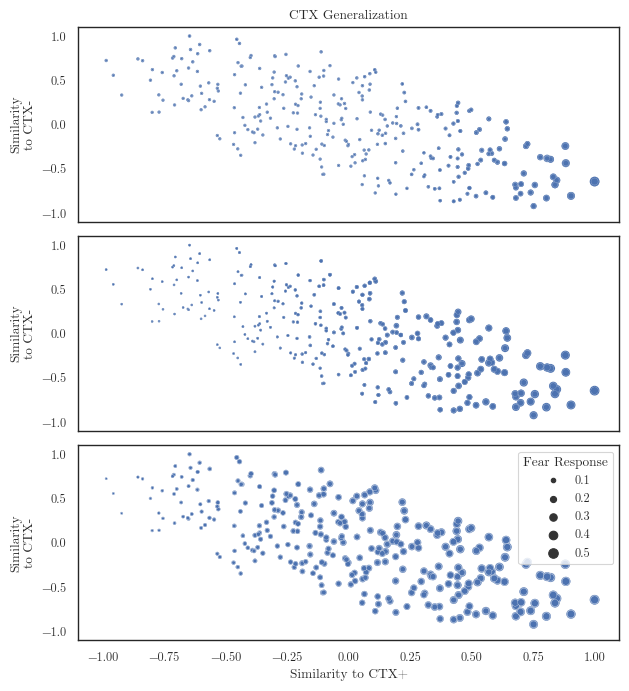

In [87]:
intercepts = [0.6, 0.3, 0.0]
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=((6.38,7)))

for i, intercept in enumerate(intercepts):
    data = pd.read_pickle(f"generalization_CTX_intercept{intercept}.pkl")
#     data['Fear Response'] = [np.around(x, 2) for x in data["Fear Response"]]
#     data['Fear Response'] = data['Fear Response'].astype("category")
#     print(np.max(data['Fear Response'].to_numpy()))

    sns.scatterplot(data=data, x='Similarity to CTX+', y="Similarity to CTX-",
        size="Fear Response", sizes=((1, 50)), ax=axes[i])                    
#         hue="Fear Response", palette="viridis", ax=axes[i],
#         hue_norm=(0, 0.5), edgecolor="none", linewidth=0, legend="full")

axes[0].set(title="CTX Generalization", xlim=((-1.1,1.1)), ylim=((-1.1,1.1)), ylabel="Similarity\nto CTX-")
axes[1].set(xlim=((-1.1,1.1)), ylim=((-1.1,1.1)), ylabel="Similarity\nto CTX-")
axes[2].set(xlim=((-1.1,1.1)), ylim=((-1.1,1.1)), ylabel="Similarity\nto CTX-")
axes[0].get_legend().remove()
axes[1].get_legend().remove()
# axes[2].legend(loc='upper right')
plt.tight_layout()
fig.savefig(f"generalization_CTX_combined.svg")
fig.savefig(f"generalization_CTX_combined.png", dpi=600)

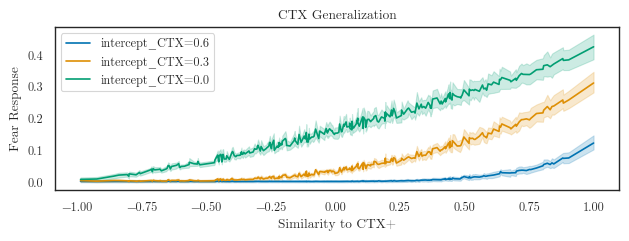

In [88]:
intercepts = [0.6, 0.3, 0.0]
fig, ax = plt.subplots(figsize=((6.38,2.5)))

for i, intercept in enumerate(intercepts):
    data = pd.read_pickle(f"generalization_CTX_intercept{intercept}.pkl")

    sns.lineplot(data=data, x='Similarity to CTX+', y="Fear Response",
        ax=ax, color=palette[i], label=f"intercept_CTX={intercept}")

ax.set(title=f"CTX Generalization")
plt.tight_layout()
fig.savefig(f"generalization_CT_combined.svg")
fig.savefig(f"generalization_CT_combined.png", dpi=600)

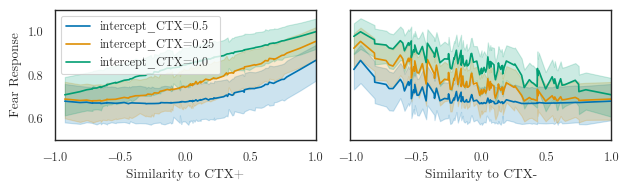

In [8]:
intercepts = [0.5, 0.25, 0.0]
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((6.38,2)))

for i, intercept in enumerate(intercepts):
    data = pd.read_pickle(f"generalization_CS+CTX_intercept{intercept}.pkl")
    sns.lineplot(data=data, x='Similarity to CTX+', y="Fear Response",
        ax=axes[0], color=palette[i], label=f"intercept_CTX={intercept}")
    sns.lineplot(data=data, x='Similarity to CTX-', y="Fear Response",
        ax=axes[1], color=palette[i], label=f"intercept_CTX={intercept}")

axes[0].set(xlim=((-1, 1)), ylim=((0.5, 1.1)))    
axes[1].set(xlim=((-1, 1)), ylim=((0.5, 1.1)))   
axes[1].get_legend().remove()
plt.tight_layout()
fig.savefig(f"generalization_CTX_extinction.svg")
fig.savefig(f"generalization_CTX_extinction.png", dpi=600)